# Benchmark: Schoof in-house dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm

import scvi

np.random.seed(0)
scvi.settings.seed = 0

Global seed set to 0


## Data loading

Let's define the path to the data and load it into anndata.

In [2]:
DATA_DIR = "../../data/schoof_inhouse/"

DATA_PATH1 = os.path.join(DATA_DIR, "carrier.h5ad")
DATA_PATH2 = os.path.join(DATA_DIR, "hBM_raw.h5ad")

In [3]:
adata1 = sc.read_h5ad(DATA_PATH1)

adata1.X[adata1.X == 0] = np.nan
adata1.X = np.log(adata1.X)

In [4]:
adata1

AnnData object with n_obs × n_vars = 562 × 3821
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways'

In [5]:
adata2 = sc.read_h5ad(DATA_PATH2)

adata2.layers["raw_sn"][adata2.layers["raw_sn"] == 0] = np.nan
adata2.layers["raw_sn"] = np.log(adata2.layers["raw_sn"])

In [6]:
adata2

AnnData object with n_obs × n_vars = 2655 × 3075
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-W', 'FSC-H', 'SSC-A', 'SSC-W', 'SSC-H', 'CD38 FACS', 'EMCN FACS', 'CD34 FACS', 'Lineage Cocktail FACS', 'CD123 FACS', 'CD90 FACS', 'CD49f FACS', 'CD45RA FACS', 'CD10 FACS', 'Time', 'Gated Population', 'Gate Path', 'QC leiden', 'Pass Cluster Filter', 'Individual', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter', 'log2_sum_filter'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways', 'n_cells'
    uns: 'Gated Population_colors', 'Sorted Population_colors'
    layers: 'raw_sn'

## PROTVI

### Training

Let's now train the model.

In [11]:
adata2.X = adata2.layers["raw_sn"].copy()
adata2.X[np.isnan(adata2.X)] = 0

In [12]:
PROTVI.setup_anndata(adata2, batch_key="Plate")

model = PROTVI(adata2, log_variational=False, decoder_type="hybrid", n_hidden=32)
#model.view_anndata_setup()

Let's train the model.

In [13]:
model.train(max_epochs=800, plan_kwargs={"mechanism_weight": 1, "lr": 1e-3}, check_val_every_n_epoch=1)#, plan_kwargs={"min_kl_weight": 10, "max_kl_weight": 10})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 800/800: 100%|██████████| 800/800 [08:39<00:00,  1.71it/s, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.43e+3]

`Trainer.fit` stopped: `max_epochs=800` reached.


Epoch 800/800: 100%|██████████| 800/800 [08:39<00:00,  1.54it/s, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.43e+3]


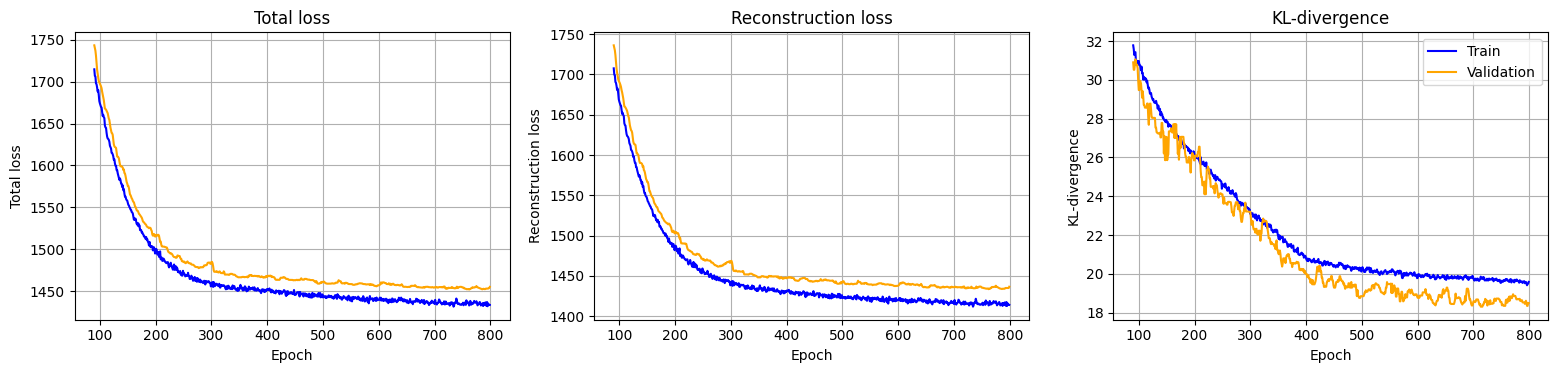

In [14]:
pl.plot_loss(model.history, epoch_start=90, validation_smooth_window=10)

### Evaluation on training set

In [15]:
x_est, p_est = model.impute()

x_data = adata2.layers["raw_sn"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

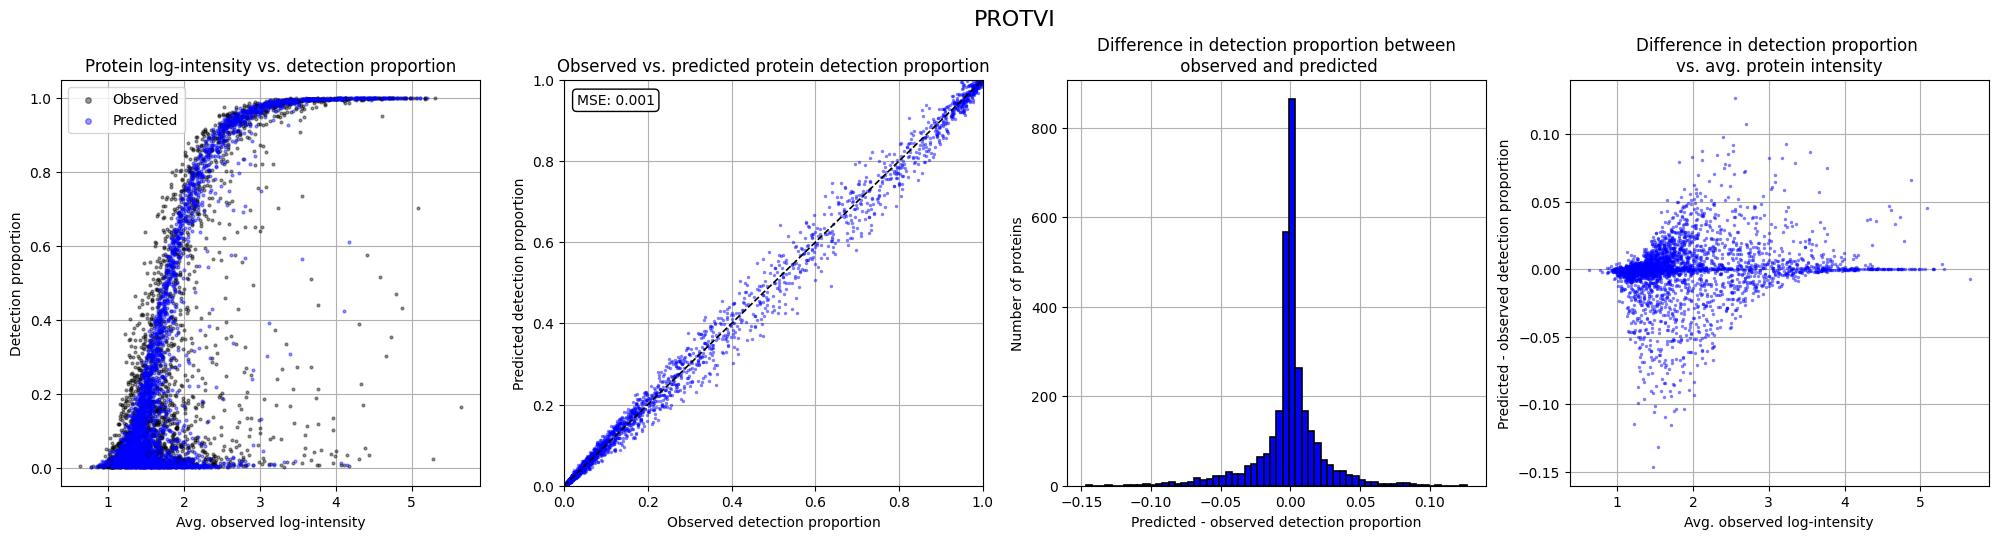

In [16]:
pl.plot_protein_detection_proportion_panel(x_data, p_est, x_est=x_est_obs)

Let's now compare the protein intensities predicted by the model and the intensities in dataset.

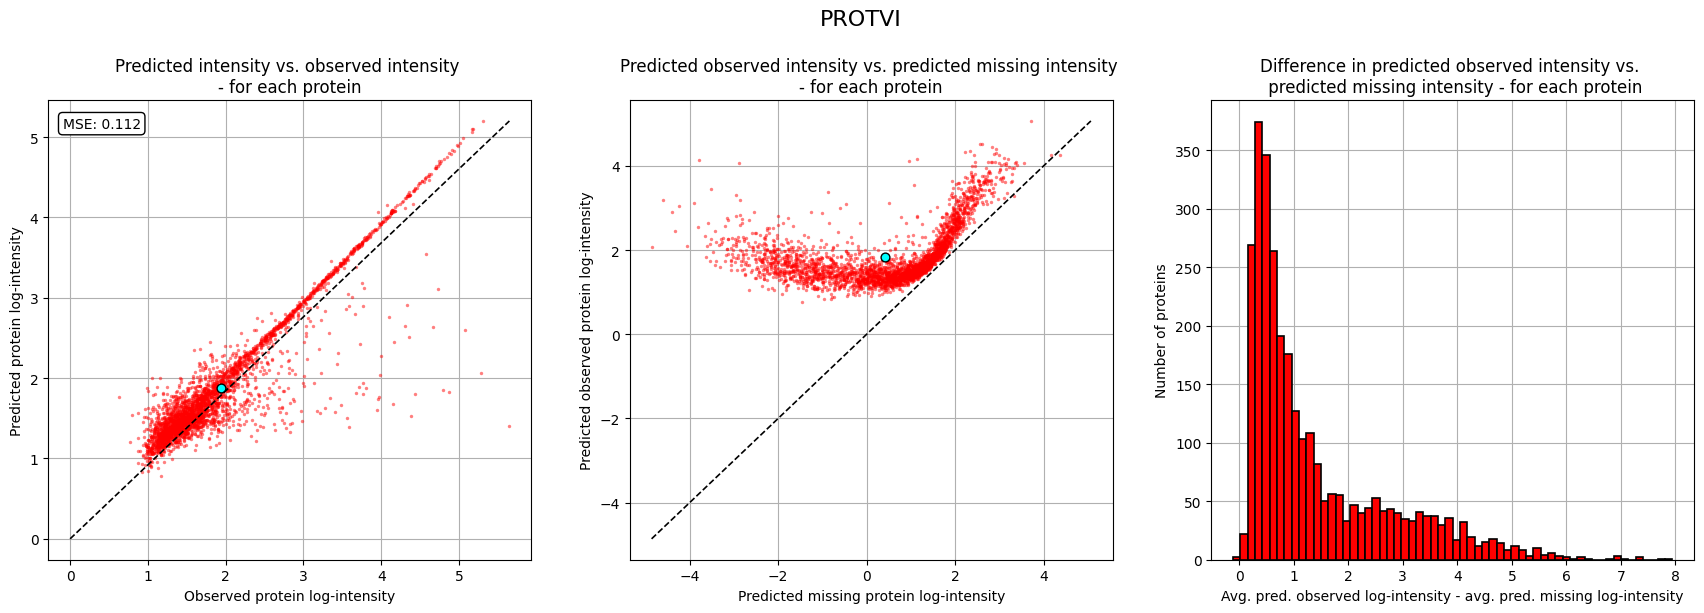

In [17]:
pl.plot_protein_intensity_panel(x_data, x_est)

Let's look at the latent space.

In [18]:
latent = model.get_latent_representation()
adata2.obsm["latent"] = latent

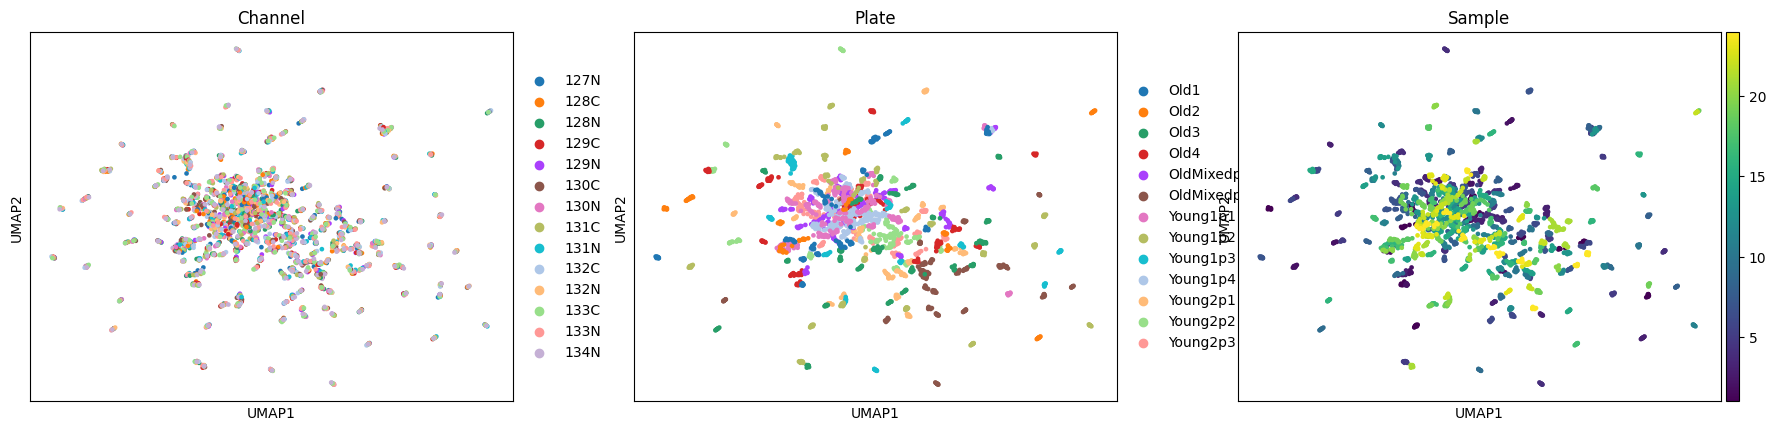

In [19]:
sc.pp.neighbors(adata2, use_rep="latent")
sc.tl.umap(adata2)

sc.pl.umap(
    adata2, 
    color=["Channel", "Plate", "Sample"], 
    vmin="p01", vmax="p99",
)

Let's see how much of the variance in the latent space can be explained by PCA.

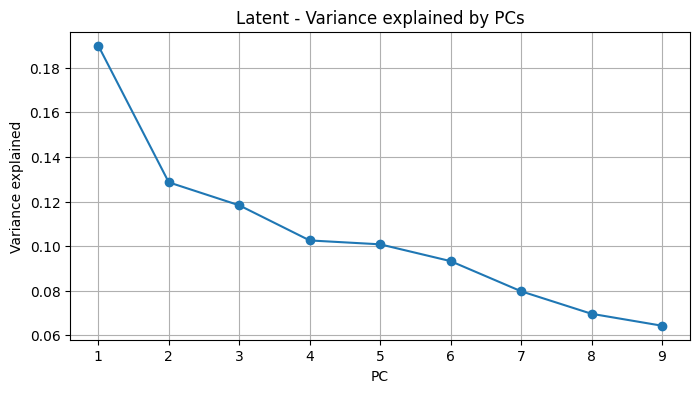

In [20]:
latent_pcs, pcs, var_ratio, var = sc.tl.pca(adata2.obsm["latent"], return_info=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(1, latent_pcs.shape[1]+1), var_ratio, marker="o")
ax.set_xticks(np.arange(1, latent_pcs.shape[1]+1))
ax.set_xlabel("PC")
ax.set_ylabel("Variance explained")
ax.set_title("Latent - Variance explained by PCs")
ax.grid(True)
ax.set_axisbelow(True)

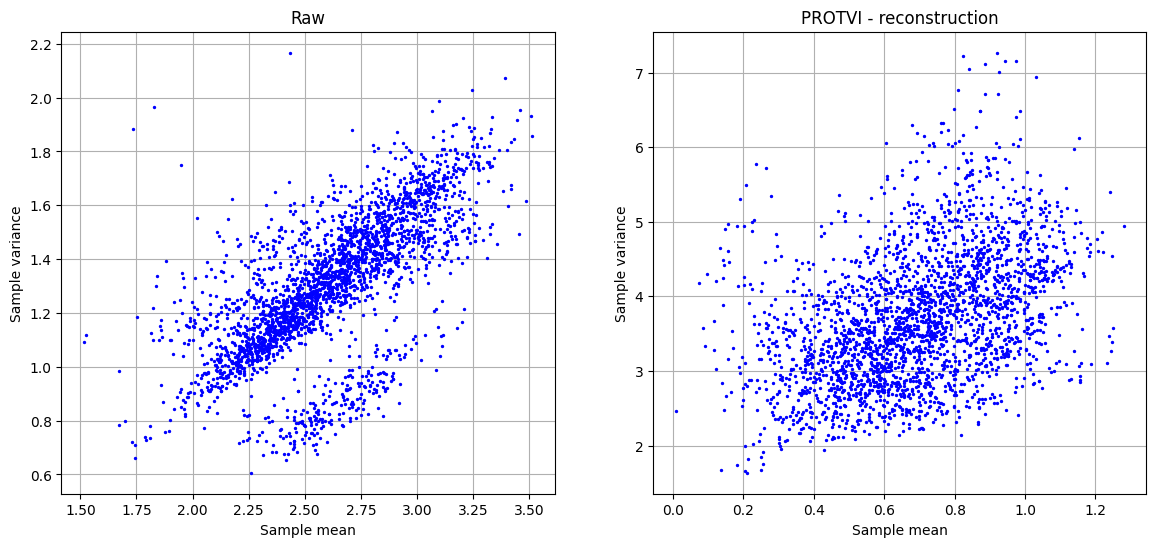

In [21]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=2)
pl.scatter_sample_mean_and_variance(adata2.layers["raw_sn"], title="Raw", ax=axes[0])
pl.scatter_sample_mean_and_variance(x_est, "PROTVI - reconstruction", ax=axes[1])

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

First, we'll fit protDP to the data.

In [22]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [23]:
r_adata = utils.prepare_anndata_for_R(adata2)

In [24]:
%%R -i r_adata
library(protDP)

X <- assay(r_adata, "raw_sn")
dpcfit <- dpc(X)

In [25]:
protdp_result = robjects.r("dpcfit")

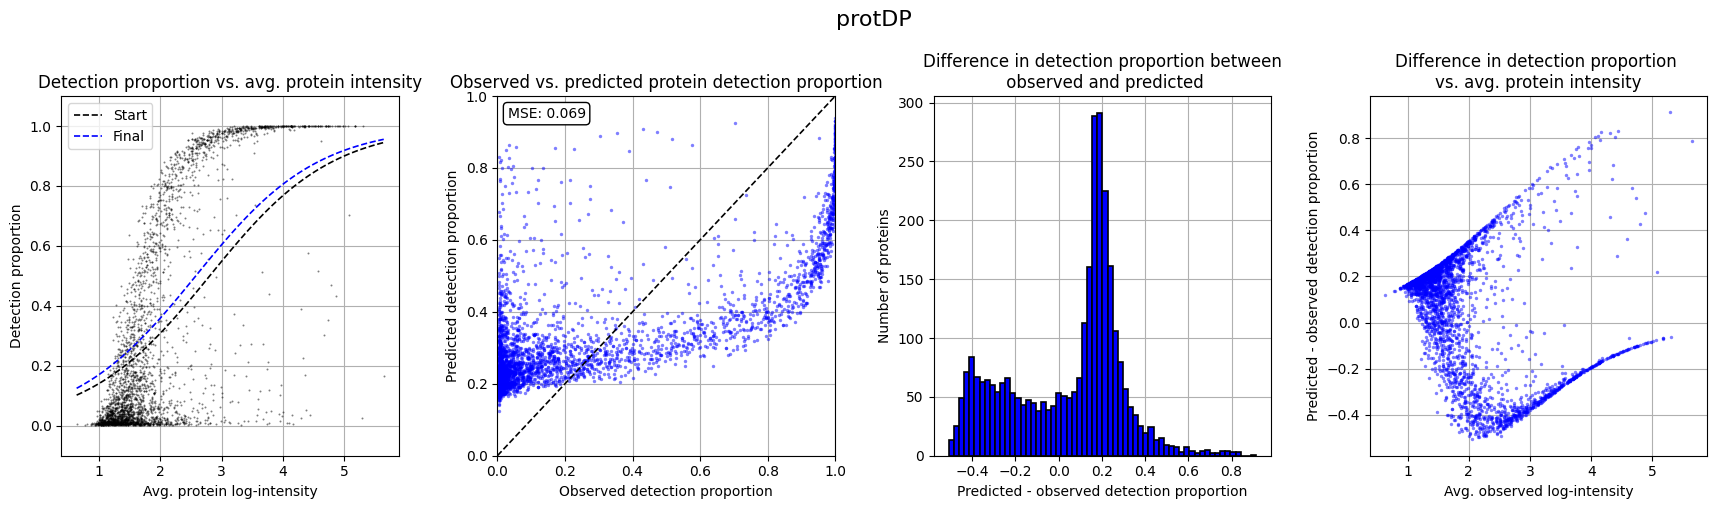

In [26]:
pl.plot_protein_detection_proportion_panel_protDP(x_data, protdp_result)

### protDP vs PROTVI

Let's compare the results of the two methods:

/tmp/ipykernel_148823/1935104467.py:8: RuntimeWarning: Mean of empty slice
  x_est_miss_protein = np.nanmean(x_est_miss, axis=0)


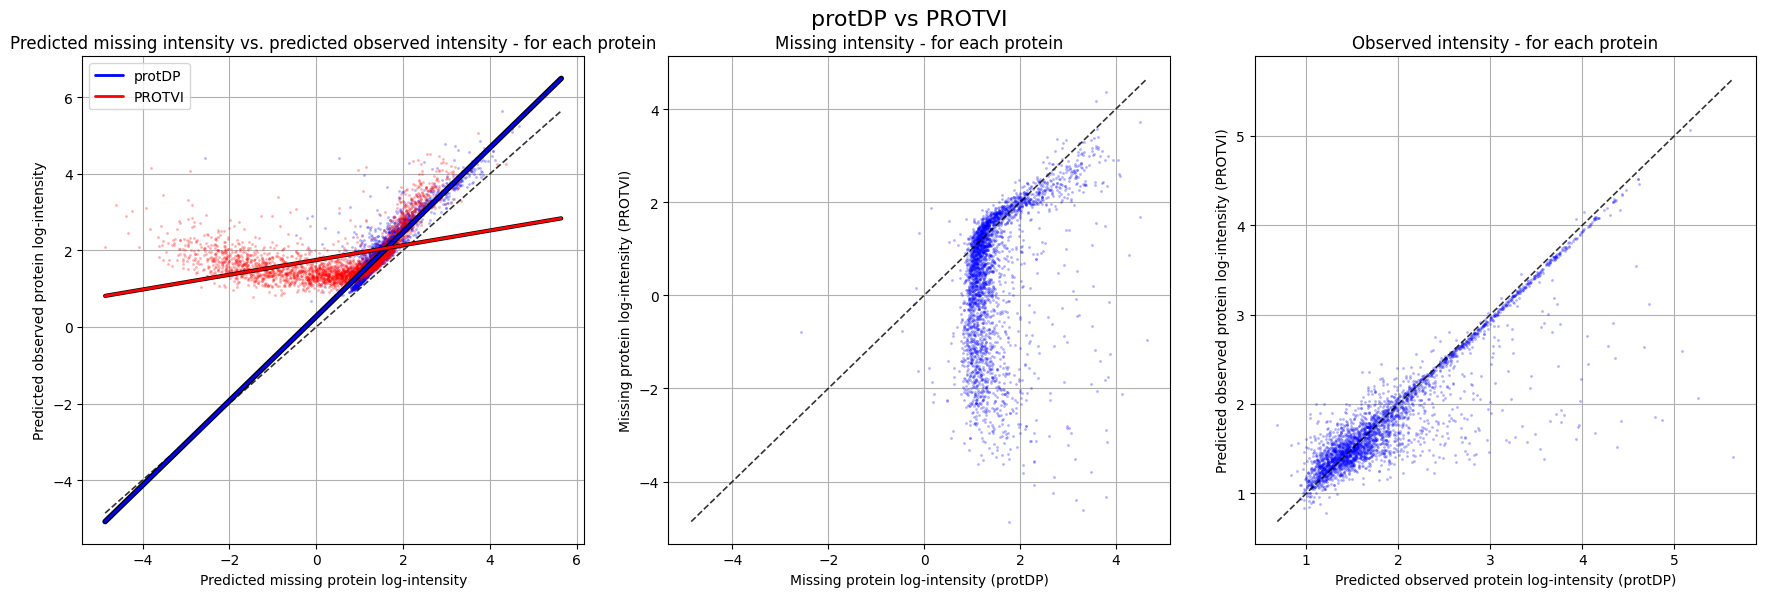

In [27]:
x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

x_est_obs_protein = np.nanmean(x_est_obs, axis=0)
x_est_miss_protein = np.nanmean(x_est_miss, axis=0)

pl.plot_model_intensity_comparison(
    x_data, 
    protdp_result["mu_obs"], 
    protdp_result["mu_mis"],
    x_est_obs_protein, 
    x_est_miss_protein,
    "protDP",
    "PROTVI"
)

In [28]:
slope, intercept = model.module.decoder.get_mask_logit_weights()

if (slope is not None) and (intercept is not None):
    x_protein = np.nanmean(x_data, axis=0)
    p_protein = 1 - np.mean(np.isnan(x_data), axis=0)
    p_est_protein = p_est.mean(axis=0)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    fig, ax = plt.subplots(figsize=(8, 5), ncols=1)

    pl.scatter_protein_detection_proportion_and_intensity(x_data, ax=ax)

    xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="black", label="protVI", linewidth=2)

    intercept, slope = protdp_result["beta"]
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="red", label="protDP", linewidth=2)
    ax.legend()